In [2]:
!pip install tqdm

In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pylab as plt
from math import *
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl

C:\Users\Mark\AppData\Local\Temp\ipykernel_26672\883644142.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [8]:
#load h5 file as a dataframe, df (r'path_of_file')
df = pd.read_hdf(r'C:\Users\Mark\Master_Algorithm-Patrick_Zong-2023-06-26\videos\2114\20210815-map2114-T_1DLC_resnet50_Master_AlgorithmJun26shuffle1_3540000_filtered.h5')
df.iloc[:5]

scorer    DLC_resnet50_Master_AlgorithmJun26shuffle1_3540000              \
bodyparts                                            noseTip               
coords                                                     x           y   
0                                                1385.014038  578.353699   
1                                                1385.014038  578.353699   
2                                                1385.014038  578.353699   
3                                                1385.014038  578.353699   
4                                                1385.014038  578.353699   

scorer                                                                 \
bodyparts                 leftEar                            rightEar   
coords    likelihood            x           y likelihood            x   
0           0.999979  1360.528320  494.738251   0.999964  1336.470825   
1           0.999979  1360.529053  494.740112   0.999964  1336.470825   
2           0.999979  1360.529053  494.740112   0.999964  1336.470825   
3           0.999979  1360.529053  494.740112   0.999963  1336.470825   
4           0.999979  1360.529053  494.739746   0.999963  1336.471191   

scorer                                                               
bodyparts                           tailBase                         
coords              y likelihood           x           y likelihood  
0          556.726013   0.999938  930.539551  635.986877   0.998894  
1          556.726013   0.999937  930.540100  635.986877   0.998895  
2          556.726013   0.999937  930.540100  635.986877   0.998895  
3          556.726013   0.999938  930.540100  635.986877   0.998895  
4          556.726013   0.999938  930.540100  635.986877   0.998895

In [9]:
def coord_extractor(df):
    
    #this function aims to extract data included in the loaded h5 file, x and y coordinates separately
    #THIS TAKES A WHILE, PROPORTIONAL TO DATAFILE SIZE
    
    #This code is agnostic of label name.. rather it assumes that the label position (i.e. column) is the same across all files..
    #dictionary accofrding to df read above:  
    #        position:      0        1         2         3
    #        label:       snout    LE        RE        TB
    
    global xcoord, ycoord

    xcoord = np.ones((len(df),4)) #making an 2D array with all the x coordinates (len(df) is number of rows AND 4 is the number of labels)
    ycoord = np.ones((len(df),4)) #making an 2D array with all the y coordinates (len(df) is number of rows AND 4 is the number of labels)

    for i in tqdm(range(0, len(df)), desc='Extracting Coordinates'): #for i in range(0, f + 2): 
        xcoord[i]= [float(df.get(df.keys()[0])[i]), float(df.get(df.keys()[3])[i]), float(df.get(df.keys()[6])[i]), float(df.get(df.keys()[9])[i])]
        ycoord[i]= [float(df.get(df.keys()[1])[i]), float(df.get(df.keys()[4])[i]), float(df.get(df.keys()[7])[i]), float(df.get(df.keys()[10])[i])]


  
    return

In [10]:
coord_extractor(df)

Extracting Coordinates: 100%|████████████████████████████████████████████████| 108299/108299 [00:43<00:00, 2494.47it/s]


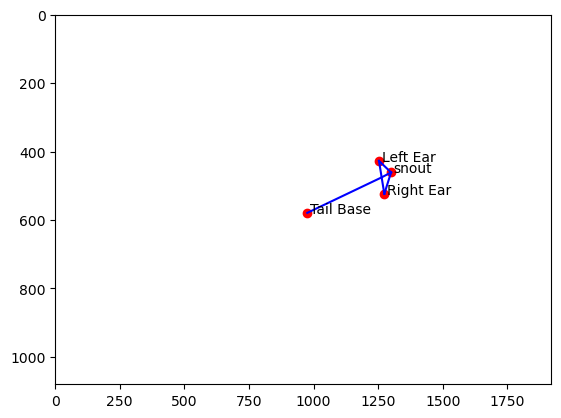

In [13]:
# example of how to view a single frame, f, as a scatter

#make sure to plot random frames (by changing f) to make sure the labels make sense 


f = 10500
plt.scatter(xcoord[f], ycoord[f], c='r')
plt.annotate('snout', xy=(xcoord[f][0]+10, ycoord[f][0]))
plt.annotate('Left Ear', xy=(xcoord[f][1]+10, ycoord[f][1]))
plt.annotate('Right Ear', xy=(xcoord[f][2]+10, ycoord[f][2]))
plt.annotate('Tail Base', xy=(xcoord[f][3]+10, ycoord[f][3]))


#draw rudimentary skeleton for check
plt.plot([xcoord[f][1], xcoord[f][2]], [ycoord[f][1], ycoord[f][2]], c='b')
plt.plot([xcoord[f][0], xcoord[f][2]], [ycoord[f][0], ycoord[f][2]], c='b')
plt.plot([xcoord[f][1], xcoord[f][0]], [ycoord[f][1], ycoord[f][0]], c='b')

mx = (xcoord[f][1]+ xcoord[f][2])/2.0    # find ear x midpoint
my = (ycoord[f][1] + ycoord[f][2])/2.0   # find ear y midpoint

plt.plot([mx, xcoord[f][0]], [my, ycoord[f][0]], c='b')
plt.plot([mx, xcoord[f][3]], [my, ycoord[f][3]], c='b')

plt.xlim(0, 1920)     ### these are just for viewing.. It would be best to get the real box (video frame) coordinates here
plt.ylim(0, 1080)
plt.gca().invert_yaxis()

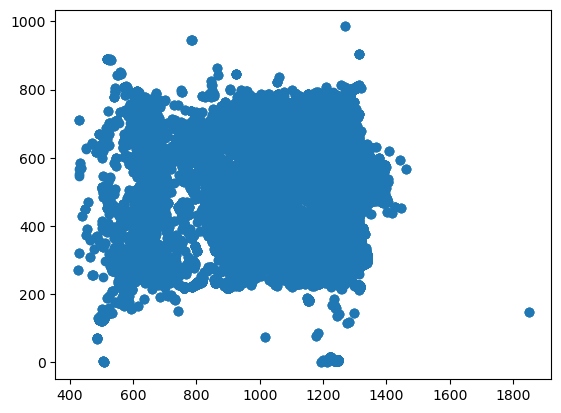

In [14]:
#plot raw data, basically the pose estimates spat out by DLC

# a little hard to interpret as it is plotting every label simultanouesly
plt.scatter(xcoord, ycoord)

#looking at this, I believe any point where X<400 and y>~900 seems artifactual (i.e. DLC is dropping labels outside the real field of view)
# there is a way to intially tell DLC to not label anything if the confidence of the label is too low at a user-defined threshold

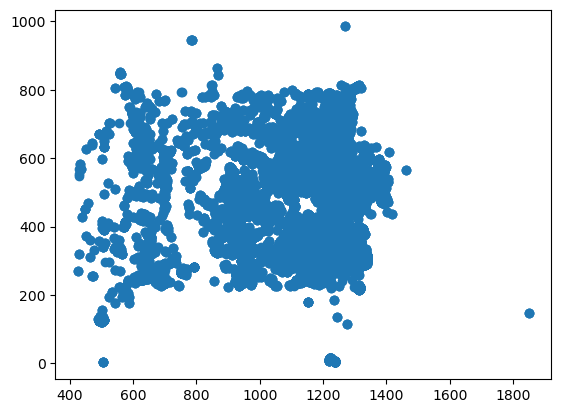

In [15]:
#let's plot scatter of snout coordinates only
plt.scatter(xcoord[:,0], ycoord[:,0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Snout Y-coord')

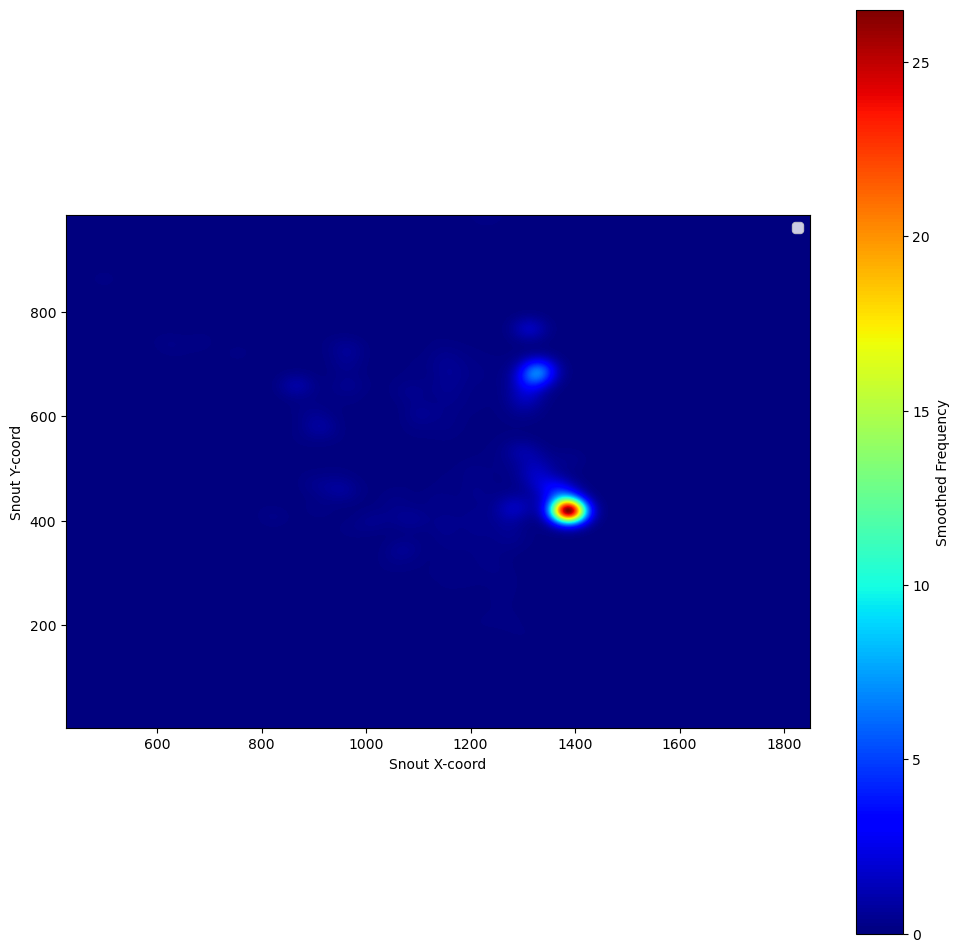

In [16]:

def heat_plotter(x,y, sigma, bins=1000):
    heat, xedge, yedge = np.histogram2d(x,y,bins=bins)
    heat = gaussian_filter(heat, sigma=sigma)
    extent = [xedge[0], xedge[-1], yedge[0], yedge[-1]]
    return heat.T, extent
    
x = xcoord[:,0]
y = ycoord[:,0]

x_clean = []
y_clean = []
for i in range(0, len(x)):
    if x[i]<200:       #arbitrary filter based on observations..
        continue
    else:
        x_clean.append(x[i])
        y_clean.append(y[i])

image, extent = heat_plotter(x_clean, y_clean, sigma=16)
fig = plt.subplots(figsize=(12,12))
plt.imshow(image, extent=extent, cmap=cm.jet)
#plt.gca().invert_yaxis()
plt.colorbar(label='Smoothed Frequency')
plt.legend()
plt.xlabel('Snout X-coord')
plt.ylabel('Snout Y-coord')


In [318]:
heat.T.shape

(1000L, 1000L)

In [45]:
def calc_metrics(xcoord, ycoord, clean=True):
    #example of how to employ a function to iterate through data and calculate something based on coordinates
    
    # clean=True is a provision that I added in case labels are very extreme (e.g. DLC stil labels things off frame when it does not know whewre they go, the label gets placed in a corner, i.e. very low values)
    
    #        position:      0        1         2         3
    #        label:       snout    LE        RE        TB
    
    
    #set up global variables that you want to access outside of the function
    global t2s, m2s, theta, dtheta
    
    
    t2s = []    #tail-to-snout distance
    for i in range(0, len(xcoord)):
        if clean ==True and xcoord[i][0]<5:
            t2s.append(np.nan)
        else:
            t2s.append(sqrt((xcoord[i][0] - xcoord[i][3])**2 + (ycoord[i][0] - ycoord[i][3])**2))
        
        
        
        
    m2s = []    # ear midpoint distance to snout
    for i in range(0, len(xcoord)):
        if clean ==True and xcoord[i][0]<5:
            m2s.append(np.nan)
        else:
            mx = (xcoord[i][1]+ xcoord[i][2])/2.0    # find ear x midpoint
            my = (ycoord[i][1] + ycoord[i][2])/2.0   # find ear y midpoint
            m2s.append(sqrt( (xcoord[i][0]-mx )**2 + (ycoord[i][0]-my)**2))
        
        
    
    theta = [] # from ear midpoint to snout
    dtheta = []  #change in delta from frame to frame
    for i in range(0, len(xcoord)):
        if clean ==True and xcoord[i][0]<5:
            theta.append(np.nan)
            dtheta.append(np.nan)
        else:
            mx = (xcoord[i][1]+ xcoord[i][2])/2.0    # find ear x midpoint
            my = (ycoord[i][1] + ycoord[i][2])/2.0   # find ear y midpoint      
            theta.append((np.arctan2([ycoord[i][0]-my], [xcoord[i][0]-mx])*180/np.pi)[0])
            dtheta.append(theta[i]-theta[i-1])

        
    
    return
    
    

In [245]:
calc_metrics(xcoord, ycoord, clean=False)

(0, 1000)

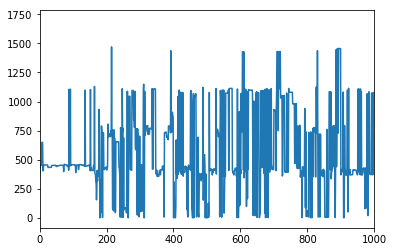

In [247]:
#sample plot at xlim, for a given measure

#if one has the stim onset/offset times, one could draw vertical lines into this plot

measure = t2s    #could be theta, dtheta, t2s, m2s, etc...

plt.plot(measure)
plt.xlim(0, 1000)

In [114]:
def theta2rad(theta):
    global rad
    
    rad=[]
    for i in range(0, len(theta)):
        rad.append(np.deg2rad(theta[i]))
        
    return

In [213]:
#SOMEONE ELSE BUILT THIS FUNCTION!!!!    https://stackoverflow.com/questions/22562364/circular-polar-histogram-in-python

def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True):
    global patches, radius, colors
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n
    
    colors = cm.viridis(radius / float(max(radius)))
    
    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='k', fill=True, linewidth=3, color=colors)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])


    return n, bins, patches

In [224]:
min(radius)

149

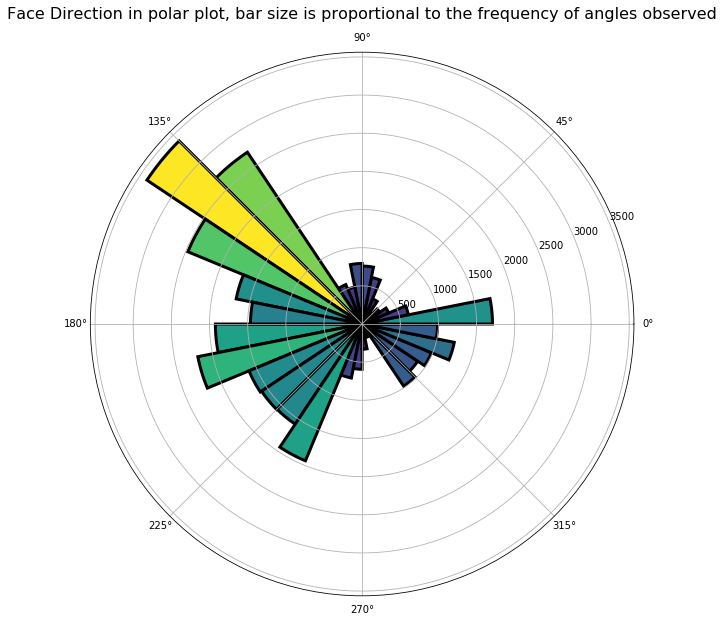

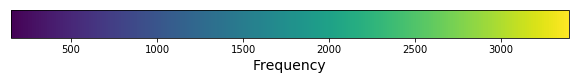

In [244]:

fig, ax = plt.subplots(figsize=(10,10), subplot_kw=dict(projection='polar'))


circular_hist(ax, np.array(rad), density=False, bins=32)  #bin value is modifiable for more refined bars (it's basically a histogram)
ax.set_title('Face Direction in polar plot, bar size is proportional to the frequency of angles observed', fontsize=16)




plt.show()

#couldnt really get the heatbar to be besides the polar plot without severe complications



cmap = mpl.cm.viridis
norm = mpl.colors.Normalize(vmin=min(radius), vmax=max(radius))
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,norm=norm,orientation='horizontal')
cb1.set_label('Frequency', fontsize=14)

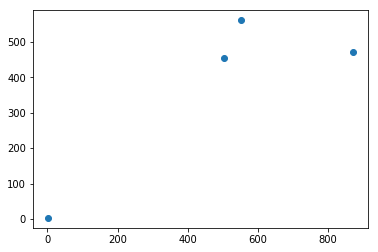

In [375]:
xcoord

# Example of how PCAing could look with xccord and ycoord

In [370]:
for i in range(0, len(xcoord)):
    if xcoord[i][0] < 5:
        print('below')

below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
below
belo

KeyboardInterrupt: 

In [376]:

#cleans up arrays if the head label is off frame

new_x = []
new_y = []

for i in range(0, len(xcoord)):
    if xcoord[i][0] < 5:
        continue
    else:
        new_x.append(xcoord[i])
        new_y.append(ycoord[i])
    
    
    
    
    

In [381]:
new_x[0][3]

914.9710540771484

In [382]:
#pca the xcoords

pca = PCA(n_components=3)
pca.fit(xcoord)  #probably redundant given next function
x_transf = pca.fit_transform(new_x)

pcx1 = x_transf[:,0]
pcx2 = x_transf[:,1]
pcx3 = x_transf[:,2]

In [383]:
#pca the ycoords

pca = PCA(n_components=3)
pca.fit(xcoord)  #probably redundant given next function
y_transf = pca.fit_transform(new_y)

pcy1 = y_transf[:,0]
pcy2 = y_transf[:,1]
pcy3 = y_transf[:,2]

Text(0,0.5,'PC1-Y')

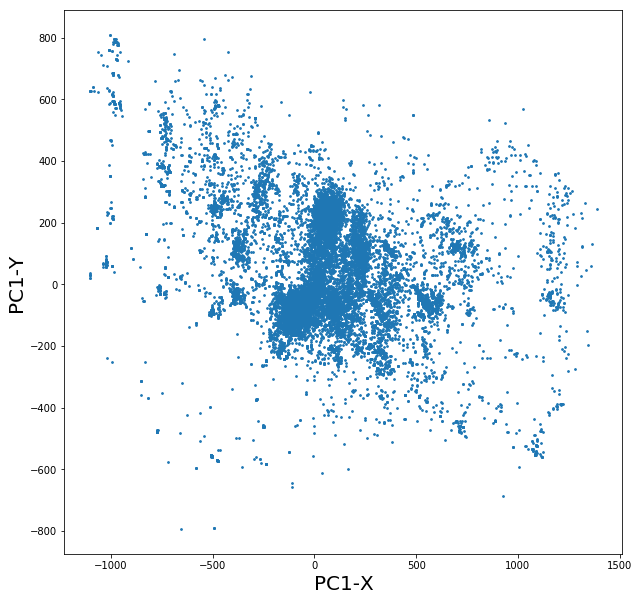

In [387]:
# THIS IS WHERE IT IS VERY USEFUL TO KNOW AT WHICH FRAMES THE SOUND IS PLAYED

fig = plt.subplots(figsize=(10,10))
plt.scatter(pcx1, pcy1, s=3)
plt.xlabel('PC1-X', fontsize=20)
plt.ylabel('PC1-Y', fontsize=20)

In [248]:
x

array([563.41949654, 505.52164936, 505.30300093, ...,   2.53744996,
         2.5374465 ,   2.53841281])

In [249]:
xcoord[:,0]

array([563.41949654, 505.52164936, 505.30300093, ...,   2.53744996,
         2.5374465 ,   2.53841281])

In [253]:
data

array([[ 45836.09941679],
       [-45836.09941679]])

In [262]:
xy = np.zeros((len(x),2))
xy[:,0] = x
xy[:,1] = y
pca = PCA(n_components=2)
data = pca.fit_transform(xy)

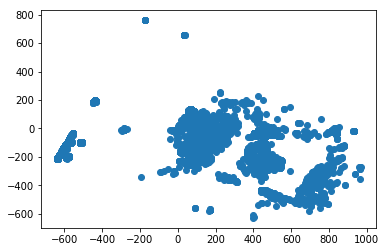

In [263]:
xs = list(range(0, len(data)))
plt.scatter(data[:,0],data[:,1])

(array([ 9023.,  9090.,  9090., 26885., 29575., 32938., 35555., 35808.,
        36274., 36319.]),
 array([-6.01504326e-01,  1.50433367e+02,  3.01468237e+02,  4.52503108e+02,
         6.03537979e+02,  7.54572850e+02,  9.05607721e+02,  1.05664259e+03,
         1.20767746e+03,  1.35871233e+03,  1.50974720e+03]),
 <a list of 1 Patch objects>)

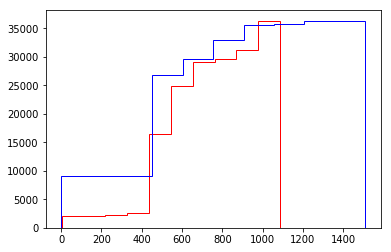

In [282]:
plt.hist(y, cumulative=True, fill=False, histtype='step', color='r')
plt.hist(x, cumulative=True, fill=False, histtype='step', color='b')
#plt.hist(data[:,0], cumulative=True, fill=False, histtype='step', color='g')
#plt.hist(data[:,1], cumulative=True, fill=False, histtype='step', color='k')

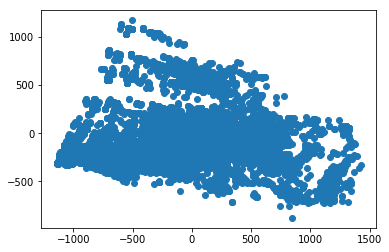

In [287]:
pca = PCA(n_components = 2)
data = np.ones((len(x), 2))
data[:,0]=pcx1
data[:,1]=pcy1
egh = pca.fit_transform(data)
plt.scatter(egh[:,0],egh[:,1])

In [294]:
vector=[]
for i in range(0, len(x)):
    vector.append(abs(sqrt(x[i]**2+y[i]**2)))
    
clean_vec = []
clean_theta=[]
for i in range(0, len(vector)):
    if vector[i]<500:
        continue
    else:
        clean_vec.append(vector[i])
        clean_theta.append(theta[i])

array([[14928.98995264,  7063.3363337 ],
       [ 7063.3363337 , 28992.72648357]])

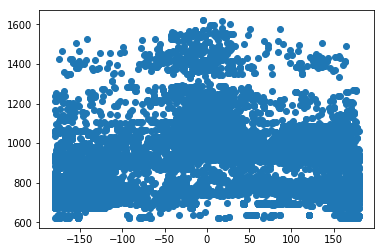

In [305]:
plt.scatter(clean_theta, clean_vec)
mean = []
for i in range(0, len(clean_theta)):
    mean.append((clean_theta[i]+clean_vec[i])/2.0)
xs = list(range(0, len(clean_theta)))
#plt.plot(xs, mean, c='r')


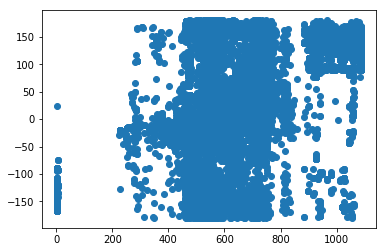

In [309]:
plt.scatter(y, theta)

In [310]:
g_df = pd.DataFrame({'x':x, 'theta':theta, 'y':y, 'vector':vector})

In [313]:
g_df

theta      vector           x           y
0      -57.148112  746.126736  563.419497  489.145762
1      119.938088  775.480691  505.521649  588.063062
2      120.130836  775.748531  505.303001  588.603993
3      146.206813  775.850204  505.801782  588.309524
4      119.836563  775.863212  505.789945  588.336855
5      119.963125  775.746883  505.630448  588.320555
6      120.024079  775.539853  505.470004  588.185463
7      145.962613  774.134974  502.641556  588.758375
8      146.578773  775.300872  504.865092  588.389905
9      146.031666  774.476988  504.099279  587.961327
10     147.511474  772.236150  503.608716  585.428844
11     147.145880  773.431119  504.362846  586.356389
12     145.031570  773.399710  507.181922  583.878077
13     144.593890  773.036825  507.027189  583.531801
14     144.816970  772.831971  506.923762  583.350284
15     145.818878  773.113162  506.957416  583.693532
16     144.820151  772.848809  506.539087  583.706634
17     144.914603  772.756090  506.700047  583.444117
18     145.719093  772.666429  506.551507  583.454353
19     144.506409  772.494011  506.446358  583.317309
20     144.722409  772.482564  506.367420  583.370677
21     145.761955  772.484496  506.399394  583.345482
22     145.704846  772.496321  506.386370  583.372447
23     145.663002  772.496028  506.378634  583.378772
24     145.168393  772.926831  506.321563  583.998597
25     145.056978  772.766099  506.362016  583.750763
26     145.102868  772.967498  507.012363  583.452840
27     145.244581  772.828285  506.762020  583.485915
28     144.746899  772.774563  506.618955  583.538996
29     144.858096  772.767501  506.631037  583.519154
...           ...         ...         ...         ...
36289 -108.923570    3.708945    2.391883    2.834637
36290 -108.928042    3.717059    2.398049    2.840051
36291 -108.929582    3.723248    2.395577    2.850225
36292 -108.921436    3.723659    2.397411    2.849221
36293  -53.043846  671.554194  488.806638  460.492243
36294  -53.027670  671.656943  488.884118  460.559842
36295  -53.025999  671.644283  488.890928  460.534149
36296  -53.007808  671.762302  488.970211  460.622106
36297  -53.007865  671.708717  488.988836  460.524179
36298  -52.983061  671.867422  488.927599  460.820611
36299  -52.981884  671.861503  488.931187  460.808175
36300  120.846496  930.517833    3.296852  930.511992
36301  120.829734  930.206275    3.767847  930.198644
36302  120.830506  930.373743    3.561614  930.366925
36303  120.885671  930.715205    3.190170  930.709738
36304  120.848374  931.018400    3.343961  931.012395
36305  120.839182  931.072836    3.387317  931.066674
36306  120.847887  931.027711    3.349977  931.021684
36307  120.869924  930.750780    3.443458  930.744410
36308  120.872646  930.982542    3.279684  930.976765
36309  120.871820  930.982748    3.278552  930.976975
36310  120.884511  930.902685    3.191718  930.897213
36311  120.886781  930.902686    3.191513  930.897215
36312 -143.653882    3.907104    2.550076    2.960165
36313 -137.852264    3.863028    2.507752    2.938395
36314 -137.869722    3.890480    2.536324    2.950067
36315 -137.857818    3.882530    2.538485    2.937708
36316 -137.858494    3.878268    2.537450    2.932970
36317 -137.867001    3.878267    2.537446    2.932971
36318 -137.874141    3.872852    2.538413    2.924970

[36319 rows x 4 columns]

In [311]:
import plotly.express as px

In [315]:
fig = px.scatter_3d(g_df, x='x', y='y', z='theta')
fig.show()